<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/cell_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
!wget https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
!unzip -o -d ./images MP6843_img_full.zip
!unzip -o -d ./labels MP6843_seg.zip
!rm *.zip

--2021-07-28 11:59:21--  https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_img_full.zip
Resolving cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)... 67.58.57.218
Connecting to cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)|67.58.57.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240194618 (229M) [application/zip]
Saving to: ‘MP6843_img_full.zip’

MP6843_img_full.zip 100%[===================>] 229.07M  41.7MB/s    in 5.9s    

2021-07-28 11:59:28 (38.7 MB/s) - ‘MP6843_img_full.zip’ saved [240194618/240194618]

--2021-07-28 11:59:28--  https://cildata.crbs.ucsd.edu/ccdb//telescience/home/CCDB_DATA_USER.portal/P2043/Experiment_6835/Subject_6837/Tissue_6840/Microscopy_6843/MP6843_seg.zip
Resolving cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)... 67.58.57.218
Connecting to cildata.crbs.ucsd.edu (cildata.crbs.ucsd.edu)|67.58.57.218|:443... connected.
HTTP request sent, aw

In [2]:
from os.path import join
from os import listdir
import numpy as np
import cv2
import torch
from torch import nn, optim, float
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt

In [3]:
im_root, lb_root = "./images", "./labels"
im_files = [join(im_root, im) for im in sorted(listdir(im_root)) if 'w1' in im]
lb_files = [join(lb_root, lb) for lb in sorted(listdir(lb_root)) if '_01' in lb]

In [4]:
dim = (696, 520)
images = [cv2.resize(cv2.imread(img), dim, interpolation = cv2.INTER_AREA) for img in im_files]
images = np.array(images)

In [5]:
labels = [cv2.imread(lbl,0) for lbl in lb_files]
labels = (np.array(labels)/255)

In [6]:
class CellImages(Dataset):
    def __init__(self, images, labels):
        self.images, self.labels = images, labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(256),
        ])
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, ind):
        img = self.transform(self.images[ind])
        lbl = self.transform(self.labels[ind])
        return img, lbl

In [7]:
train = DataLoader(CellImages(images[0:70], labels[0:70]), batch_size=10, shuffle=False)
test = DataLoader(CellImages(images[70:90], labels[70:90]), batch_size=10, shuffle=False)

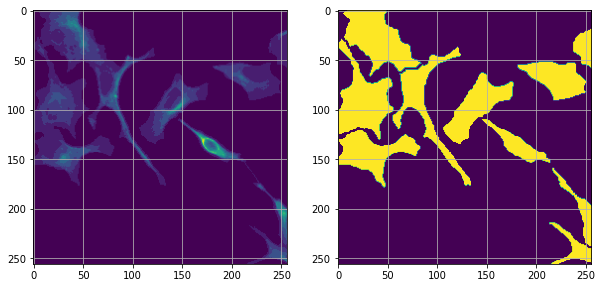

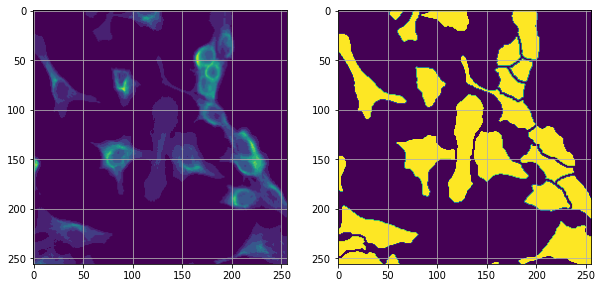

In [8]:
for i, sample in enumerate(train):
    if i == 3:
        img, lbl = sample
        for ind in range(2):
            f, ax = plt.subplots(1,2,figsize=(10,10))
            ax[0].imshow(img[ind].numpy()[0])
            ax[0].grid()
            ax[1].imshow(lbl[ind].numpy()[0])
            ax[1].grid()
        plt.show()
        break

In [9]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, (3, 3), bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.Conv2d(out_channel, out_channel, (3, 3),  bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.stack(x)
        return x

In [10]:
class UNet(nn.Module):
    def __init__(self, channels, output_size, final_output=1):
        super(UNet, self).__init__()
        self.down, self.up = channels, [c for c in reversed(channels[1:])]  # Number of feature channels
        self.down_layers, self.up_layers = nn.ModuleList(), nn.ModuleList()
        self.output_size = output_size
        self.build_layers(final_output)  # Generate list of required modules
        self.features = []

    def forward(self, x):
        output = self.expansive(self.contracting(x))
        output = F.interpolate(output, self.output_size)
        return output

    def build_layers(self, final):
        # Generate sequence layer for the expansive & contracting path
        for i in range(len(self.down) - 1):
            self.down_layers.append(Block(self.down[i], self.down[i + 1]))
            if i != max(range(len(self.down) - 1)):
                self.down_layers.append(nn.MaxPool2d((2, 2), stride=2))  # 2x2 max pooling
                self.up_layers.append(nn.ConvTranspose2d(self.up[i], self.up[i + 1], (2, 2), stride=2))
                self.up_layers.append(Block(self.up[i], self.up[i + 1]))
            else:
                self.up_layers.append(nn.Conv2d(self.up[-1], final, (1, 1)))  # 1x1 convolutional layer

    def contracting(self, model):
        """3x3 convolutions & ReLU followed by 2x2 max pooling for downsampling"""
        for i in range(0, len(self.down_layers) - 1, 2):
            block = self.down_layers[i](model)
            self.features.append(block)  # Store block outputs for concatenation
            model = self.down_layers[i + 1](block)
        model = self.down_layers[-1](model)
        return model

    def expansive(self, model):
        """Upsampling followed by 3x3 convolutions & ReLU"""
        for i in range(0, len(self.up_layers) - 1, 2):
            block = self.up_layers[i](model)
            feature = self.crop(self.features[::-1][int(i / 2)], block)
            block = torch.cat([block, feature], dim=1)  # Double the number of feature channels
            model = self.up_layers[i + 1](block)
        model = self.up_layers[-1](model)
        return model

    def crop(self, feature, block):  # Necessary due to loss of border pixels every convolution
        _, _, h, w = block.shape
        feature = transforms.CenterCrop([h, w])(feature)
        return feature

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """Training batch to update weights and biases"""
    size = len(dataloader.dataset)
    for i, (img, lbl) in enumerate(dataloader):
        img_batch, lbl_batch = img.to('cuda'), lbl.to('cuda')
        loss = loss_fn(model(img_batch.float()), lbl_batch)

        # Backpropagation to adjust the weights and biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss, current = loss.detach().item(), (i + 1) * len(img_batch)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
def test_loop(dataloader, model, loss_fn):
    "Validation batch for each epoch"
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    x, y = output_size

    with torch.no_grad():
        for (img, lbl) in dataloader:
            img_batch, lbl_batch = img.to('cuda'), lbl.to('cuda')
            pred = model(img_batch.float())
            test_loss += loss_fn(pred, lbl_batch).detach().item()
            out = (nn.Sigmoid()(pred) > 0.5).float()
            correct = (torch.eq(out, lbl_batch).sum() / out.numel())

    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return out, lbl_batch

In [13]:
output_size = (256, 256)
channels = [3, 64, 128, 256]
handler = UNet(channels, output_size).to('cuda')
loss_fn = nn.BCEWithLogitsLoss()
optimiser = optim.Adam(handler.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimiser, max_lr=5e-3, steps_per_epoch=len(train), epochs=5)

In [14]:
for t in range(5):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train, handler, loss_fn, optimiser)
    test_loop(test, handler, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 0.731761  [   10/   70]
loss: 0.638880  [   20/   70]
loss: 0.587269  [   30/   70]
loss: 0.541532  [   40/   70]
loss: 0.536454  [   50/   70]
loss: 0.492458  [   60/   70]
loss: 0.457931  [   70/   70]
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.423717 

Epoch 2
-------------------------------
loss: 0.551538  [   10/   70]
loss: 0.564049  [   20/   70]
loss: 0.620019  [   30/   70]
loss: 0.506279  [   40/   70]
loss: 0.541476  [   50/   70]
loss: 0.423863  [   60/   70]
loss: 0.380147  [   70/   70]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.352762 

Epoch 3
-------------------------------
loss: 0.596191  [   10/   70]
loss: 0.674979  [   20/   70]
loss: 0.545024  [   30/   70]
loss: 0.458944  [   40/   70]
loss: 0.508400  [   50/   70]
loss: 0.314665  [   60/   70]
loss: 0.306185  [   70/   70]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.308391 

Epoch 4
-------------------------------
loss: 0.538377  [   10/   70]
loss: 0.597547  [   20/   70]
loss: 0.511949  [   30/   70]
loss

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.295897 



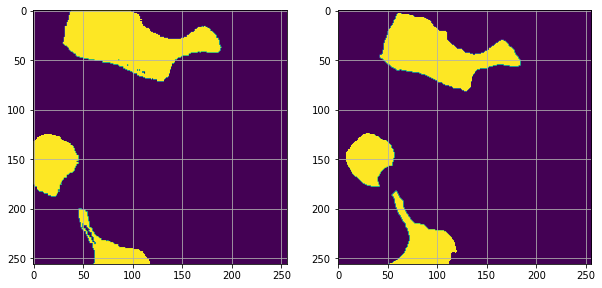

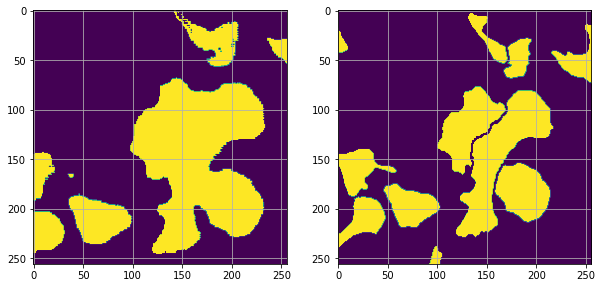

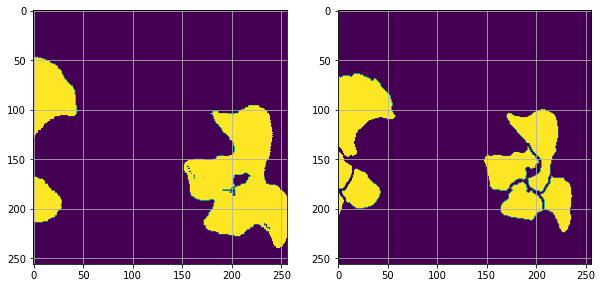

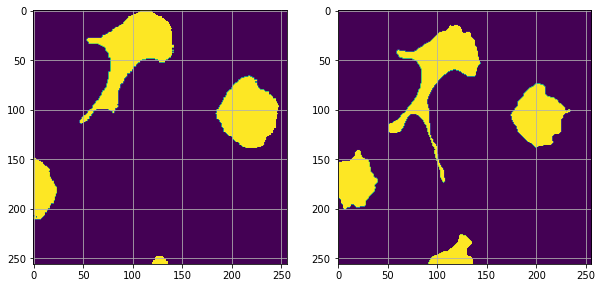

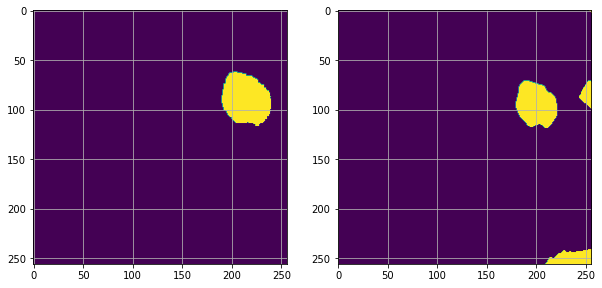

In [15]:
unseen = DataLoader(CellImages(images[95:100], labels[95:100]), batch_size=5, shuffle=False)
pred, ans = test_loop(unseen, handler, loss_fn)

for i in range(5):
    f, ax = plt.subplots(1,2,figsize=(10,10))
    ax[0].imshow(pred[i].cpu().numpy()[0])
    ax[0].grid()
    ax[1].imshow(ans[i].cpu().numpy()[0])
    ax[1].grid()
    plt.show()